In [1]:
!pip install seaborn 
!pip install pandas
!pip install esda
!pip install pysal
!pip install splot
!pip install geopandas 
!pip install numpy 
!pip install contextily
!pip install matplotlib

     |████████████████████████████████| 95 kB 4.2 MB/s 
     |████████████████████████████████| 2.4 MB 41.7 MB/s 
  Created wheel for esda: filename=esda-2.4.1-py3-none-any.whl size=117429 sha256=294eef1cbde583d5adea2efe4ce7ec16701fb02d7a6c83f9a870ebbf852ee208
  Stored in directory: /root/.cache/pip/wheels/ed/67/c5/4558a178be4c410f341c31f71b5aba9c761a40c9d17dbdfddd
Successfully built esda
     |████████████████████████████████| 46 kB 4.5 MB/s 
     |████████████████████████████████| 60 kB 8.4 MB/s 
     |████████████████████████████████| 164 kB 64.8 MB/s 
     |████████████████████████████████| 209 kB 45.9 MB/s 
     |████████████████████████████████| 41 kB 770 kB/s 
     |████████████████████████████████| 81 kB 10.1 MB/s 
     |████████████████████████████████| 5.7 MB 46.0 MB/s 
     |████████████████████████████████| 243 kB 47.9 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 269 kB 48.3 MB/s 
     |███████████████████████████████

In [2]:
import seaborn as sns
import pandas as pd
import esda
from pysal.lib import weights
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation
)
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
# Read the file in
br = gpd.read_file(
    "http://darribas.org/gds_course/content/data/brexit.gpkg"
)

In [4]:
# Index table on the LAD ID
br = br.set_index("lad16cd", drop=False)
# Display summary
br.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000024
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int64   
 1   lad16cd    380 non-null    object  
 2   lad16nm    380 non-null    object  
 3   Pct_Leave  380 non-null    float64 
 4   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 17.8+ KB


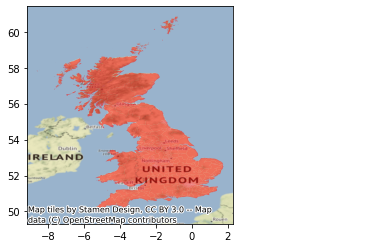

In [5]:
# Plot polygons
ax = br.plot(alpha=0.5, color='red');
# Add background map, expressing target CRS so the basemap can be
# reprojected (warped)
ctx.add_basemap(ax, crs=br.crs)

In [6]:
# Create the spatial weights matrix
%time w = weights.Queen.from_dataframe(br, idVariable="lad16cd")

CPU times: user 3.5 s, sys: 117 ms, total: 3.62 s
Wall time: 3.99 s


/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 6 islands with ids: E06000046, E06000053, S12000013, S12000023, S12000027, W06000001.
  warnings.warn(message)


In [7]:
w['E08000012']

{'E06000006': 1.0, 'E08000011': 1.0, 'E08000014': 1.0}

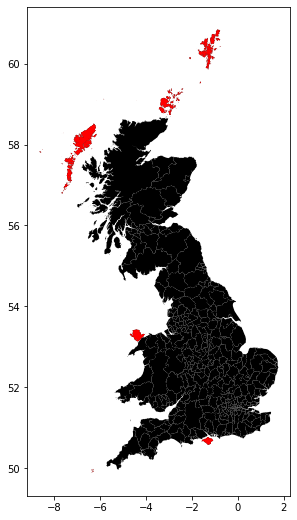

In [8]:
ax = br.plot(color='k', figsize=(9, 9))
br.loc[w.islands, :].plot(color='red', ax=ax);

In [9]:
br = br.drop(w.islands)

In [10]:
# Create the spatial weights matrix
# NOTE: this might take a few minutes as the geometries are
#       are very detailed
%time w = weights.Queen.from_dataframe(br, idVariable="lad16cd")

CPU times: user 2.89 s, sys: 67.9 ms, total: 2.95 s
Wall time: 3.42 s


In [11]:
# Row standardize the matrix
w.transform = 'R'

In [12]:
w['E08000012']

{'E06000006': 0.3333333333333333,
 'E08000011': 0.3333333333333333,
 'E08000014': 0.3333333333333333}

In [13]:
br['w_Pct_Leave'] = weights.lag_spatial(w, br['Pct_Leave'])

In [14]:
br[['lad16cd', 'Pct_Leave', 'w_Pct_Leave']].head()

,lad16cd,Pct_Leave,w_Pct_Leave
lad16cd,,,
E06000001,E06000001,69.57,59.640000
E06000002,E06000002,65.48,60.526667
E06000003,E06000003,66.19,60.376667
E06000004,E06000004,61.73,60.488000
E06000005,E06000005,56.18,57.430000


In [15]:
w.neighbors['E06000001']

['E06000004', 'E06000047']

In [16]:
neis = br.loc[w.neighbors['E06000001'], 'Pct_Leave']
neis

lad16cd
E06000004    61.73
E06000047    57.55
Name: Pct_Leave, dtype: float64

In [17]:
neis.mean()

59.64

In [18]:
br['Pct_Leave_std'] = (
    br['Pct_Leave'] - br['Pct_Leave'].mean()
) / br['Pct_Leave'].std()

In [19]:
br['w_Pct_Leave_std'] = weights.lag_spatial(w, br['Pct_Leave_std'])

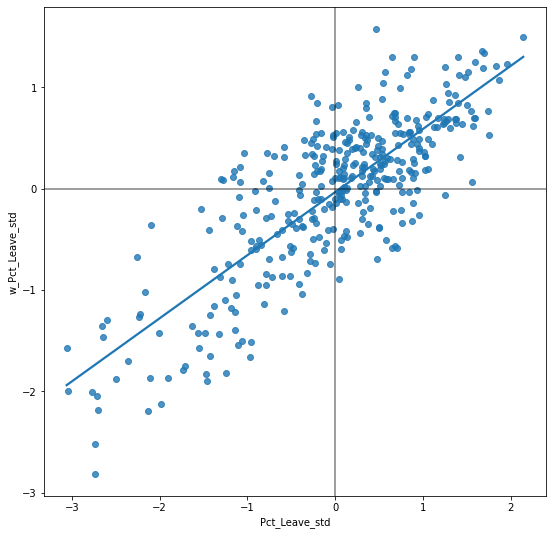

In [20]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=br, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

In [21]:
mi = esda.Moran(br['Pct_Leave'], w)

In [22]:
mi.I

0.6228641407137806

In [23]:
mi.p_sim

0.001

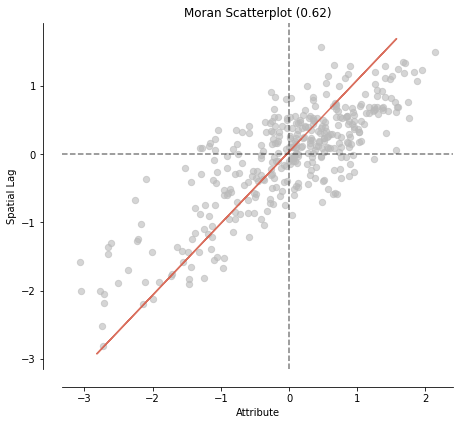

In [24]:
moran_scatterplot(mi);

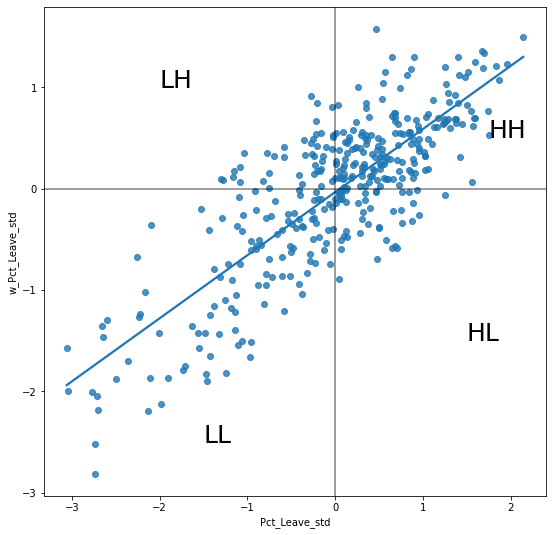

In [25]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=br, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.75, 0.5, "HH", fontsize=25)
plt.text(1.5, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1.5, -2.5, "LL", fontsize=25)
# Display
plt.show()

In [26]:
lisa = esda.Moran_Local(br['Pct_Leave'], w)

In [27]:
# Break observations into significant or not
br['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
br['quadrant'] = lisa.q

In [28]:
br['significant'].head()

lad16cd
E06000001    False
E06000002    False
E06000003    False
E06000004    False
E06000005    False
Name: significant, dtype: bool

In [29]:
lisa.p_sim[:5]

array([0.175, 0.092, 0.1  , 0.052, 0.184])

In [30]:
br['quadrant'].head()

lad16cd
E06000001    1
E06000002    1
E06000003    1
E06000004    1
E06000005    1
Name: quadrant, dtype: int64

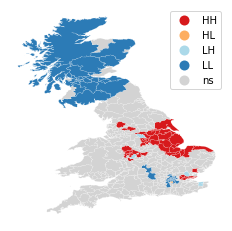

In [31]:
lisa_cluster(lisa, br);

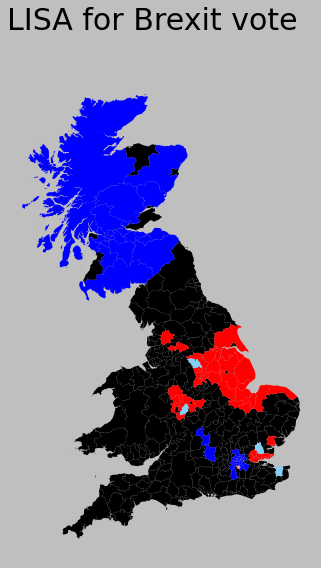

In [32]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot insignificant clusters
ns = br.loc[br['significant']==False, 'geometry']
ns.plot(ax=ax, color='k')
# Plot HH clusters
hh = br.loc[(br['quadrant']==1) & (br['significant']==True), 'geometry']
hh.plot(ax=ax, color='red')
# Plot LL clusters
ll = br.loc[(br['quadrant']==3) & (br['significant']==True), 'geometry']
ll.plot(ax=ax, color='blue')
# Plot LH clusters
lh = br.loc[(br['quadrant']==2) & (br['significant']==True), 'geometry']
lh.plot(ax=ax, color='#83cef4')
# Plot HL clusters
hl = br.loc[(br['quadrant']==4) & (br['significant']==True), 'geometry']
hl.plot(ax=ax, color='#e59696')
# Style and draw
f.suptitle('LISA for Brexit vote', size=30)
f.set_facecolor('0.75')
ax.set_axis_off()
plt.show()

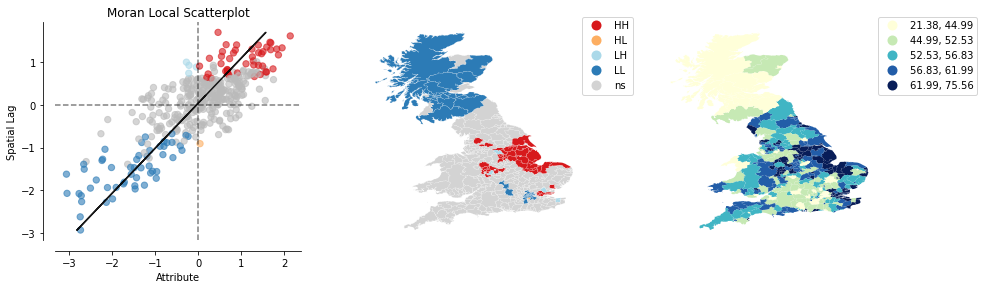

In [33]:
plot_local_autocorrelation(lisa, br, 'Pct_Leave');